# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [184]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
! ls /content/gdrive/My\ Drive/Colab\ Notebooks/data

test_32x32.mat	train_32x32.mat


In [6]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/My Drive/Colab Notebooks/data/train_32x32.mat')
test = loadmat('/content/gdrive/My Drive/Colab Notebooks/data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [7]:
def get_train_test_data(train_data, test_data):
    x_train, y_train = train_data['X'], train_data['y']
    x_test, y_test = test_data['X'], test_data['y']
    # Set labels between 0 and 9
    y_train -= 1
    y_test -= 1
    # transpose to batch size first
    x_train = np.transpose(x_train, (3, 0, 1, 2))
    x_test = np.transpose(x_test, (3, 0, 1, 2))
    # min - max: 0 - 255
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    return x_train, y_train, x_test, y_test

In [8]:
x_train, y_train, x_test, y_test = get_train_test_data(train, test)
print(f'x_train shape is: {x_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'x_test shape is: {x_test.shape}')
print(f'y_test shape is: {y_test.shape}')
print(f'x_train data: min value is {np.min(x_train)} and max value is {np.max(x_train)}')
print(f'x_test data: min value is {np.min(x_test)} and max value is {np.max(x_test)}')
print(f'y_train data: min value is {np.min(y_train)} and max value is {np.max(y_train)}')
print(f'y_test data: min value is {np.min(y_test)} and max value is {np.max(y_test)}')

x_train shape is: (73257, 32, 32, 3)
y_train shape is: (73257, 1)
x_test shape is: (26032, 32, 32, 3)
y_test shape is: (26032, 1)
x_train data: min value is 0.0 and max value is 1.0
x_test data: min value is 0.0 and max value is 1.0
y_train data: min value is 0 and max value is 9
y_test data: min value is 0 and max value is 9


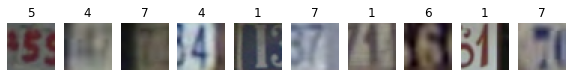

In [9]:
num_imgs = 10
fig, ax = plt.subplots(1, num_imgs, figsize=(num_imgs, 1))
random_sample = random.sample(range(len(x_train)), num_imgs)

for idx, sample in enumerate(random_sample):
    ax[idx].set_axis_off()
    ax[idx].imshow(x_train[sample])
    ax[idx].set_title(y_train[sample][0] + 1)

In [10]:
x_train = np.mean(x_train, axis = 3)[..., np.newaxis]
x_test = np.mean(x_test, axis = 3)[..., np.newaxis]

In [11]:
print(f'x_train shape is: {x_train.shape}')
print(f'x_test shape is: {x_test.shape}')

x_train shape is: (73257, 32, 32, 1)
x_test shape is: (26032, 32, 32, 1)


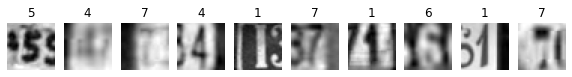

In [12]:
fig, ax = plt.subplots(1, num_imgs, figsize=(num_imgs, 1))
for idx, sample in enumerate(random_sample):
    ax[idx].set_axis_off()
    ax[idx].imshow(np.squeeze(x_train[sample]), cmap='gray')
    ax[idx].set_title(y_train[sample][0] + 1)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [236]:
def get_mlp_model(input_shape):
    model = Sequential([
        Flatten(input_shape = input_shape),
        Dense(64, activation = 'relu'),
        Dense(128, activation = 'relu'),
        BatchNormalization(),
        Dense(32, activation = 'relu'),
        Dropout(0.3),
        Dense(10, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [250]:
model = get_mlp_model(x_train[0].shape)
model.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_50 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_208 (Dense)            (None, 64)                65600     
_________________________________________________________________
dense_209 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
_________________________________________________________________
dense_210 (Dense)            (None, 32)                4128      
_________________________________________________________________
dropout_90 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_211 (Dense)            (None, 10)              

In [251]:
def get_checkpoints():
    best_model = ModelCheckpoint('mlp/checkpoints_best_only/checkpoint', 
                                 monitor = 'val_accuracy', save_weights_only = True,
                                 save_best_only = True)
    early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 4)
    return [best_model, early_stopping]

In [252]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 64, validation_split = 0.15, callbacks = get_checkpoints())

Epoch 1/30
973/973 [==============================] - 3s 3ms/step - loss: 1.7271 - accuracy: 0.4129 - val_loss: 2.6140 - val_accuracy: 0.2908
Epoch 2/30
973/973 [==============================] - 3s 3ms/step - loss: 1.3707 - accuracy: 0.5597 - val_loss: 1.3708 - val_accuracy: 0.5599
Epoch 3/30
973/973 [==============================] - 3s 3ms/step - loss: 1.2798 - accuracy: 0.5921 - val_loss: 1.1212 - val_accuracy: 0.6476
Epoch 4/30
973/973 [==============================] - 3s 3ms/step - loss: 1.2196 - accuracy: 0.6145 - val_loss: 1.0994 - val_accuracy: 0.6506
Epoch 5/30
973/973 [==============================] - 3s 3ms/step - loss: 1.1843 - accuracy: 0.6240 - val_loss: 1.2774 - val_accuracy: 0.6029
Epoch 6/30
973/973 [==============================] - 3s 3ms/step - loss: 1.1516 - accuracy: 0.6354 - val_loss: 1.0081 - val_accuracy: 0.6794
Epoch 7/30
973/973 [==============================] - 3s 3ms/step - loss: 1.1134 - accuracy: 0.6452 - val_loss: 1.1432 - val_accuracy: 0.6378
Epoch 

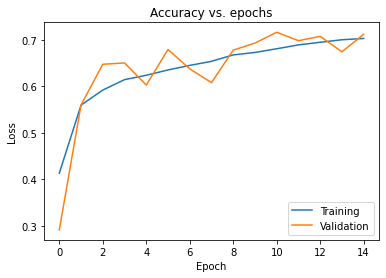

In [253]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

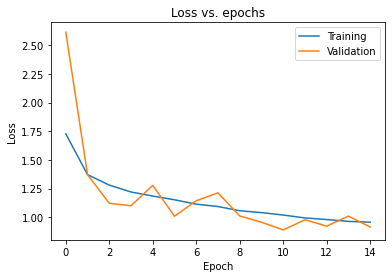

In [254]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [259]:
model = get_mlp_model(x_train[0].shape)
model.load_weights('mlp/checkpoints_best_only/checkpoint')
test_loss, test_acc = model.evaluate(x = x_test, y = y_test, verbose = 0)
print('Loss in test set is {:.02f} and Accuracy in test set is {:.02f}'.format(test_loss, test_acc))

Loss in test set is 0.98 and Accuracy in test set is 0.70


https://github.com/palashsharma891/Street-View-House-Numbers/blob/master/Classifier.ipynb

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.